In [1]:
import os
import os.path
from os import walk
from os.path import join
import numpy as np

base_path = '/workspace/lianxi/Kaggle/car_recognition/'

def get_picture(path):
    path0 = join(base_path + path)
    picture = []
    for _,_,filenames in walk(path0):
        for filename in filenames:
            file_prefix = os.path.splitext(filename)[0]
            if os.path.exists(join(path0, file_prefix + ".jpg")):
                picture.append(filename)
            elif os.path.exists(join(path0, file_prefix + ".gif")):
                picture.append(filename)
            else:
                print("路径不对或者没有这种格式的文件")
    return picture

In [2]:
car_pictures = get_picture("train")

mask_pictures = get_picture("train_masks")

len(car_pictures), len(mask_pictures)

(5088, 5088)

In [3]:
train_set = car_pictures[0:3801]
valid_set = car_pictures[3801:5068]
test_set = car_pictures[5068:5073]
print(len(train_set),'\n',len(valid_set),'\n',len(test_set))

3801 
 1267 
 5


In [4]:
test = get_picture('test')
print(test[0])

a8f9c534f544_04.jpg


In [5]:
def predict_from_model(patch, model):
    
    prediction = model.predict(patch.reshape(1, 128, 128, 3))
    prediction = prediction[:, :, :, 1].reshape(128, 128)
    return prediction

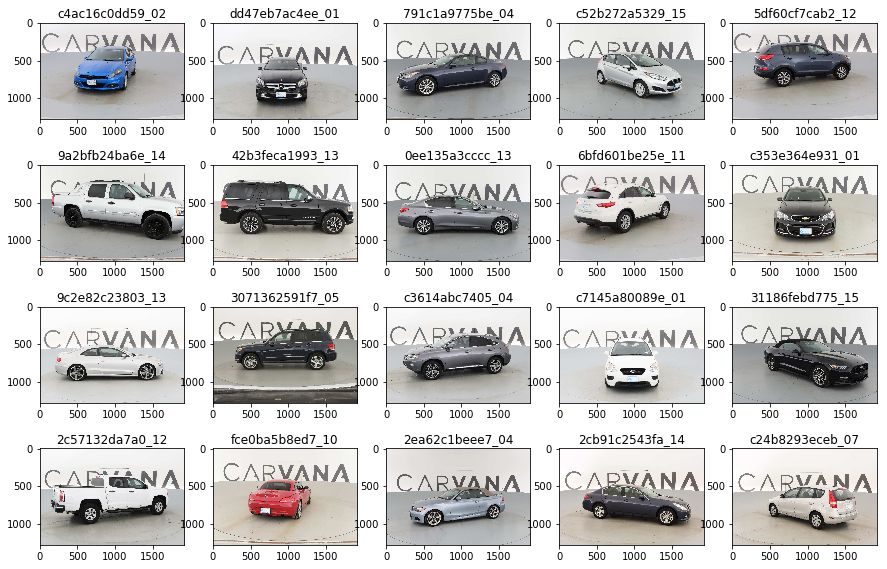

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

f, axes = plt.subplots(4,5,figsize=(15, 10))

for i in range(len(test_set)):
    order_path = join(base_path, "train/" + test_set[i])    
    car_pic = Image.open(order_path)   
    ax = axes.ravel()
    _ = ax[i].imshow(car_pic)
    _ = ax[i].set_title(os.path.splitext(test_set[i])[0])

(1918, 1280)


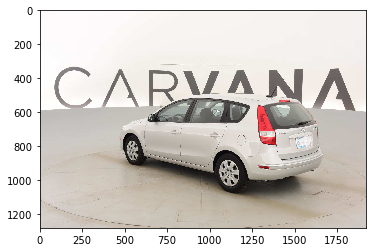

In [6]:
print(car_pic.size)

plt.imshow(car_pic)
plt.show()

In [6]:
# 定义预测整张汽车图片的函数
def image_prediction(model, car_pic, widths=128, heights=128):
    pat_pred = np.zeros((128, 1920))
    for i in range(car_pic.size[1]//heights):
        pat_pre = np.zeros((128,128))
        for j in range(car_pic.size[0]//widths):
            pat = car_pic.crop((j*widths,i*widths,(j+1)*widths,(i+1)*heights))
            pat_array = np.array(pat)
            pre_pat = predict_from_model(pat_array, model)
            pat_pre = np.hstack((pat_pre, pre_pat))
        pat_pred = np.vstack((pat_pred, pat_pre))
#     print((np.array(pat_pred)).shape)
    predic01 = np.array(pat_pred)
    for k in range(widths):    # 去掉两行,1 pixel
        predic01 = np.delete(predic01,k,1)
        predic01 = np.delete(predic01,k,0)
    predic02 = np.column_stack((predic01,(np.zeros((1280,126))).astype(int)))    # 增加一排,126 pixel
#     print(predic02.shape)
    return predic02

In [8]:
# from keras.models import load_model

# model = load_model('./model_64_200.h5')
# predic02 = image_prediction(model, car_pic)

Using TensorFlow backend.


(1408, 1920)
(1280, 1918)


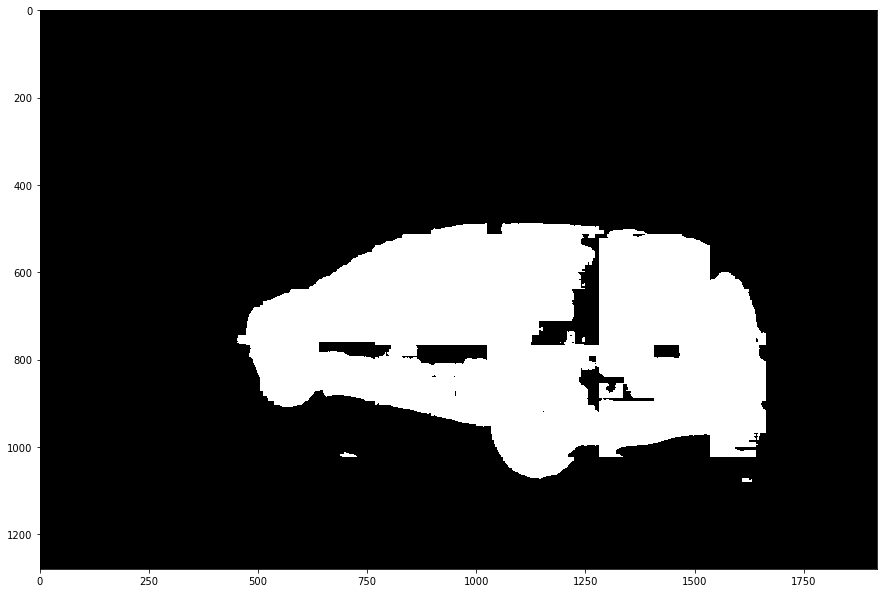

In [9]:
# from keras.preprocessing import image
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow((predic02>0.5).astype(np.int),cmap='gray',vmin=0,vmax=1)    # 此处设置了一个阈值——0.5，即预测的每一个像素概率，大于0.5的就输出

以上预测结果已经出来，下面对预测结果做处理、评价，用行程长度编码(Run Length Encoding)做存储。

    当前：[1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
    目标：[0 3 4 1 7 2 10 3 19 7]
    步骤：一、找到非零元素的角标，[0 1 2 4 7 8 10 11 12 19 20 21 22 23 24 25]
        二、去除重复元素的角标，[0 4 7 10 19]
        三、找到元素1的重复数，[3 1 2 3 7]         

In [7]:
import numpy as np

def pred_by_threshold(prediction, threshold):
    '''
    本函数通过设置阈值，归一化预测结果。
    
    输入：
        prediction:h5预测的结果，是一个概率矩阵
        threshold:阈值，取值范围是0-1之间
    输出：
        pred_bin:一维二值数组
        pred_one_index:一维角标数组，pred_bin非零元素的角标组成的数组
    '''
    pred_th = []
    for i in range(prediction.shape[0]):
        for j in range(prediction.shape[1]):
            if prediction[i][j] > threshold:
                pred_th.append(1)
            else:
                pred_th.append(0)
    pred_bin = np.array(pred_th)
    pred_one_index = np.array(np.nonzero(pred_bin))
    return pred_bin, pred_one_index

In [ ]:
# a5,b5 = pred_by_threshold(predic02, 0.5)
# print(a5.shape[0], b5.shape[1])

In [8]:
def first_half(pred_one_index):
    '''
    操作角标的函数，将数组中比前一元素大1的元素挑出来，并且删除，eg：
        input: [1,2,3,4,9,11,15,17,18,19]
        output: [2,3,4,18,19]
        output2: [1,9,11,15,17]

    输入：
        预测矩阵的非零元素的角标数组
    输出：
        非连续的数字元素组成的新数组
    '''
    array_p = pred_one_index[0][:]
    re_index = []
    for index, item in enumerate(array_p):
        if index>0 and array_p[index]-array_p[index-1] == 1:
            re_index.append(index)
    fh = np.delete(array_p, re_index, 0)
    return fh

In [ ]:
# fh = first_half(b5[0][:])
# print(fh.shape)

In [9]:
from itertools import groupby

def RLE(data):
    x = []
    jiaobiao = []
    for name, group in groupby(data):
        if name == 1:
            x.append(len(list(group)))
    yield x

In [10]:
def second_half(pred_bin):
    second_half = next(RLE(pred_bin))
#     print(len(second_half))
    return second_half

In [11]:
def rle_mask(first_half, second_half):
    '''
    Input:
        first_half:[0,4,7,10,19]
        second_half:[3,1,2,3,7]
    Output:
        [0,3,4,1,7,2,10,3,19,7]
    '''
    rle_element = (np.ones((2*len(second_half)))).astype(int)    # 定义行程长度数组
#     print(rle_element,'\n')
    for i in range(first_half.shape[0]):
        rle_element[i*2] =  first_half[i]
        rle_element[i*2+1] = second_half[i]
#     print(rle_element,'\n')
    rle_mask = []
    for i in range(rle_element.shape[0]):
        rle_mask.append(rle_element[i])
    return rle_mask

In [12]:
from keras.models import load_model

model = load_model('./model_64_200.h5')

Using TensorFlow backend.


In [13]:
from PIL import Image
import csv
import time

start_time = time.clock()

csvfile = open('submit.csv','w')
fieldnames = ['img', 'rle_mask']
writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
writer.writeheader()

for i in range(len(test_set)):
    order_path = join(base_path, "train/" + test_set[i])    
    car_pic = Image.open(order_path)   
    image_pred = image_prediction(model, car_pic)
    pred_bin, pred_one_index = pred_by_threshold(image_pred, 0.5)
    first_h = first_half(pred_one_index)
    second_h = second_half(pred_bin)
    rle_mask_value = rle_mask(first_h, second_h)
    writer.writerow({'img': test_set[i], 'rle_mask': (str(rle_mask_value)).replace(',','').replace('[','').replace(']','')})

end_time = time.clock()
print('Time consuming: %s s'%(end_time-start_time))

Time consuming: 50.387957 s
